In [1]:
import os
import pandas as pd
from tensorflow.keras.models import load_model
from transformer_layers import *

In [124]:
T = 100
horizon = 4   # 0=10, 1=20, 2=30, 3=50, 4=100
#start_capital = 10000
day = 1
asset = 1

In [3]:
current_path = os.getcwd()
deeplob_model = load_model('static\deeplob_serving_model.h5', custom_objects={'PositionalEncodingLayer': PositionalEncodingLayer,
                                                                              "MultiHeadSelfAttention": MultiHeadSelfAttention,
                                                                              "TransformerTransition": TransformerTransition})

In [135]:
def load_lob_data(day, T=T):
    lob_data = np.loadtxt(f"static/data/lobdata_day_{day}.txt")
    lob_data = np.array(lob_data[:40, :].T)
    
    best_asks = lob_data[:,0]
    difference_best_asks = best_asks - np.roll(best_asks, 1)
    split = (abs(difference_best_asks) > 0.03).nonzero()[0]
    split = np.append(split, len(best_asks))

    lob_data_assets = {"all": lob_data}
    for i in range(5):
        lob_data_assets[f"asset_{i+1}"] = lob_data[split[i]:split[i+1], :]
        
    return lob_data_assets

In [136]:
def predict(lob_data, T=T, horizon=horizon):
    [N, D] = lob_data.shape
    df = np.array(lob_data)
    input_data = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        input_data[i - T] = df[i - T:i, :]
    input_data = input_data.reshape(input_data.shape + (1,))

    predictions = deeplob_model.predict(input_data)
    predicted_directions = np.argmax(predictions[:, horizon], axis=1)

    return predicted_directions

In [137]:
def backtester(lob_data, predictions):
    
    
    return backtest_df, backtest_kpis

In [138]:
lob_data = load_lob_data(2)

In [139]:
preds = predict(lob_data[f"asset_{asset}"])

,ask,bid,prediction,shares_held,ask_change,bid_change,return,shares_held_change,profit,cumulative_profit
99,0.3648,0.3640,2,0.0,NaN,NaN,0.0000,0.0,0.0000,0.0000
100,0.3649,0.3645,2,0.0,0.0001,0.0005,0.0000,0.0,0.0000,0.0000
101,0.3649,0.3645,2,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
102,0.3649,0.3645,2,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
103,0.3649,0.3645,2,0.0,0.0000,0.0000,0.0000,-1.0,0.0000,0.0000
104,0.3650,0.3645,0,-1.0,0.0001,0.0000,0.0001,0.0,0.0001,0.0001
105,0.3651,0.3645,0,-1.0,0.0001,0.0000,0.0001,0.0,0.0001,0.0002
106,0.3650,0.3645,0,-1.0,-0.0001,0.0000,-0.0001,0.0,-0.0001,0.0001
107,0.3651,0.3645,0,-1.0,0.0001,0.0000,0.0001,0.0,0.0001,0.0002
108,0.3651,0.3645,0,-1.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0002


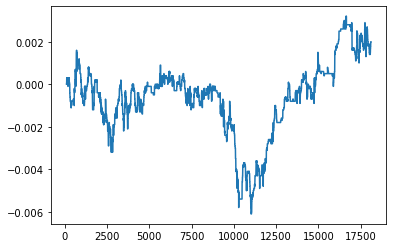

In [126]:
df = pd.DataFrame(data=lob_data[f"asset_{asset}"][:, [0,2]], columns=[ "ask", "bid"])
df = df.iloc[T-1: , :]
df["prediction"] = preds

df["shares_held"] = np.nan
df.loc[df["prediction"] == 1, "shares_held"] = 1
df.loc[df["prediction"] == 2, "shares_held"] = -1
df["shares_held"] = df["shares_held"].shift(5, fill_value=0)
df["shares_held"].fillna(method="ffill", inplace=True)

df["ask_change"] = df["ask"] - df["ask"].shift(1)
df["bid_change"] = df["bid"] - df["bid"].shift(1)

df["return"] = 0
df.loc[df["shares_held"] > 0, "return"] = df["bid_change"]
df.loc[df["shares_held"] < 0, "return"] = df["ask_change"]

df["shares_held_change"] = df["shares_held"].shift(-1, fill_value=0) - df["shares_held"]
#df["cost"] = df["shares_held_change"] * (df["ask"] - df["bid"]) * (df["shares_held_change"] > 0)

df["profit"] = df["return"]#- df["cost"]
df["cumulative_profit"] = df["profit"].cumsum()

df["cumulative_profit"].plot()
df.head(20)

<AxesSubplot:>

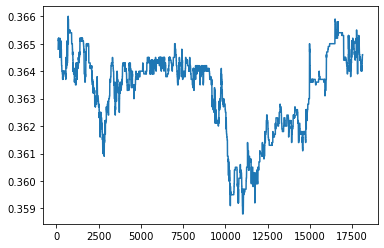

In [127]:
df["ask"].plot()